<a href="https://www.kaggle.com/code/rasheedj/braintumourdetectormodel?scriptVersionId=214018789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!gdown 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=390e1cfb-3e76-4666-84ef-fbea78b53438
To: /kaggle/working/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:03<00:00, 41.3MB/s]


In [2]:
!unzip -q brain_tumor.zip

In [3]:
ls -l

total 152172
-rw-r--r-- 1 root root 155791278 Apr  5  2024 brain_tumor.zip
---------- 1 root root     22281 Dec 20 13:12 __notebook__.ipynb
drwxr-xr-x 6 root root      4096 Dec 20 13:12 Testing/
drwxr-xr-x 6 root root      4096 Dec 20 13:12 Training/


In [4]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab




The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 132 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (337 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
Selecting previously unselected package tree.
(Reading database ... 127365 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [6]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, models





print('TF Version:', tf.__version__)

TF Version: 2.17.0


In [8]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [9]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


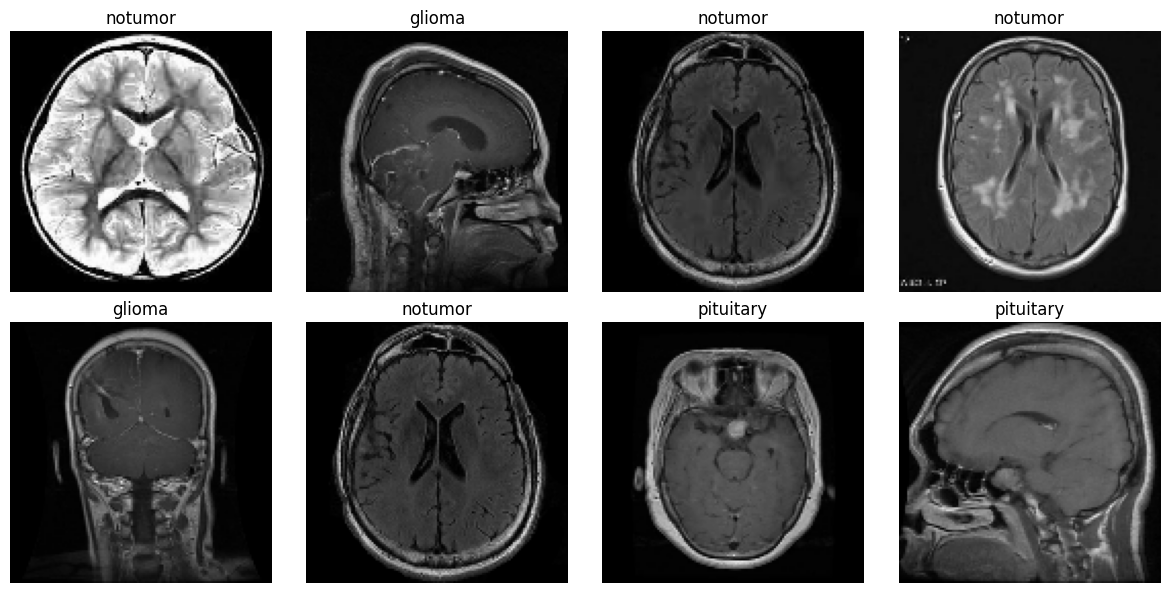

In [10]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
plt.tight_layout()

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(IMG_SHAPE)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SHAPE), include_top=False, weights='imagenet')
base_model.trainable = False
num_classes = 4

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:

base_model.trainable = True  # Unfreeze the base model
# Fine-tune the model
model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    #optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping,]
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 318ms/step - accuracy: 0.4399 - loss: 1.3604 - val_accuracy: 0.7513 - val_loss: 0.6619
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.8096 - loss: 0.5431 - val_accuracy: 0.8389 - val_loss: 0.4926
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8946 - loss: 0.3176 - val_accuracy: 0.8792 - val_loss: 0.3795
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9288 - loss: 0.2136 - val_accuracy: 0.9194 - val_loss: 0.2407
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.9526 - loss: 0.1475 - val_accuracy: 0.9422 - val_loss: 0.1653
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.9670 - loss: 0.1141 - val_accuracy: 0.9536 - val_loss: 0.1236
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.9814 - loss: 0.0736 - val_accuracy: 0.9518 - val_loss: 0.1179
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.9850 - loss: 0

In [16]:
# Save the model to a specified file
model.save('my_model.keras')  

In [17]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:03<00:32,  3.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:13,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:02,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:01,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  3.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  3.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


In [18]:
import seaborn as sns

predicted_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.93      0.92       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

